# Robyn: Advanced Marketing Mix Modeling (Source Implementation)

This notebook demonstrates how to use Robyn's core components directly for advanced Marketing Mix Modeling (MMM). This approach provides more granular control over the modeling process.

## Installation

Install Robyn using pip:

- pip install robynpy

## Import Required Libraries

We'll import the core components directly from Robyn's source:

In [1]:
import sys

sys.path.append("/Users/yijuilee/robynpy_release_reviews/Robyn/python/src")

import pandas as pd
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.enums import AdstockType
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.entities.enums import NevergradAlgorithm, Models
from robyn.modeling.feature_engineering import FeatureEngineering

2024-12-06 18:55:15,713 - robyn - INFO - Logging is set up to console only.
/Users/yijuilee/robynpy_release_reviews/robynvenv_py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

For this demonstration, we'll use simulated data:

In [2]:
# Read the simulated data and holidays data
dt_simulated_weekly = pd.read_csv("resources/dt_simulated_weekly.csv")

dt_prophet_holidays = pd.read_csv("resources/dt_prophet_holidays.csv")

## Configure MMM Data

Define the model specification including dependent variables, independent variables, and analysis window. Here's what each parameter means:

### Key Components:
- `dep_var`: Your target metric (e.g., "revenue", "conversions")
- `dep_var_type`: Type of dependent variable ("revenue" for ROI or "conversion" for CPA)
- `date_var`: Column name containing dates
- `window_start/end`: Analysis time period

### Variable Types:
- `paid_media_spends`: Columns containing media spend data (e.g., TV, Facebook, Search)
- `paid_media_vars`: Media exposure metrics (impressions, clicks) in same order as spends
- `context_vars`: External factors (e.g., competitor activities, events, seasonality)
- `organic_vars`: Marketing activities without direct spend (e.g., email, social posts)

Example configuration:

In [3]:
def setup_mmm_data(dt_simulated_weekly) -> MMMData:

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        context_vars=["competitor_sales_B", "events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(dt_simulated_weekly)
mmm_data.data.head()

,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,22358.346667,0.0,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,na,19401.653846
1,2015-11-30,2.584277e+06,28613.453333,0.0,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,na,14791.000000
2,2015-12-07,2.547387e+06,0.000000,132278.4,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,na,14544.000000
3,2015-12-14,2.875220e+06,83450.306667,0.0,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,na,2800.000000
4,2015-12-21,2.215953e+06,0.000000,277336.0,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,na,15478.000000


## Feature Engineering Setup

Configure hyperparameters and holiday data for feature preprocessing:

## Configure Hyperparameters

Hyperparameters control how media effects are modeled. Each channel requires three key parameters:

### Media Channel Parameters:
- `alphas`: Controls saturation curve shape [0.5, 3]
  - Lower values (0.5-1): More diminishing returns
  - Higher values (2-3): More S-shaped response
  
- `gammas`: Controls saturation curve inflection point [0.3, 1]
  - Lower values: Earlier diminishing returns
  - Higher values: Later diminishing returns

- `thetas`: Controls adstock decay rate [0, 0.8]
  - Lower values (0-0.2): Fast decay (e.g., Search, Social)
  - Medium values (0.1-0.4): Medium decay (e.g., Print, OOH)
  - Higher values (0.3-0.8): Slow decay (e.g., TV)

### Global Parameters:
- `adstock`: Type of carryover effect modeling
  - "geometric": Fixed decay rate
  - "weibull_cdf": Flexible decay with cumulative distribution
  - "weibull_pdf": Flexible decay with potential peak delay

- `lambda_`: Ridge regression regularization [0, 1]
- `train_size`: Proportion of data for training [0.5, 0.8]

In [4]:
hyperparameters = Hyperparameters(
    {
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=[0, 1],
    train_size=[0.5, 0.8],
)

print("Hyperparameters setup complete.")

Hyperparameters setup complete.


## Configure Holiday Data

Holiday data helps capture seasonality and special events in your model. The HolidaysData configuration includes:

### Components:
- `dt_holidays`: DataFrame containing holiday/events data
- `prophet_vars`: Time components to model:
  - "trend": Long-term trend
  - "season": Seasonal patterns
  - "holiday": Holiday/event effects
- `prophet_country`: Country code for built-in holidays (e.g., "DE" for Germany)
- `prophet_signs`: Effect direction for each prophet_var:
  - "default": Let the model determine direction
  - "positive": Force positive effect
  - "negative": Force negative effect

Note: You can add custom events (school breaks, promotional periods, etc.) to the holidays data.

In [5]:
# Create HolidaysData object
holidays_data = HolidaysData(
    dt_holidays=dt_prophet_holidays,
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)

## Perform Feature Engineering

Process and transform features using the FeatureEngineering component:

In [6]:
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)

featurized_mmm_data = feature_engineering.perform_feature_engineering()

2024-12-06 18:55:17,229 - robyn.modeling.feature_engineering - INFO - Starting feature engineering process
2024-12-06 18:55:17,231 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
2024-12-06 18:55:17,231 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/data/entities/mmmdata.py:262: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_columns = ~selected_columns.applymap(
/Users/yijuilee/robynpy_release_reviews/robynvenv_py3.10/lib/python3.10/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
202

## Visualize Feature Relationships

Plot spend-exposure relationships for channels:

In [7]:
from robyn.visualization.feature_visualization import FeaturePlotter
import matplotlib.pyplot as plt
%matplotlib inline

feature_plotter = FeaturePlotter(mmm_data, hyperparameters, featurized_mmm_data)
results_list = featurized_mmm_data.modNLS["results"]

for result in results_list:
    channel = result["channel"]
    try:
        fig = feature_plotter.plot_spend_exposure(channel)
        plt.show()
    except ValueError as e:
        print(f"Skipping {channel}: {str(e)}")

2024-12-06 18:55:17,902 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-12-06 18:55:17,903 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-12-06 18:55:17,903 - robyn.visualization.feature_visualization - INFO - Initializing FeaturePlotter
2024-12-06 18:55:17,903 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: facebook_I
2024-12-06 18:55:17,903 - robyn.visualization.feature_visualization - INFO - Found result for channel facebook_I
2024-12-06 18:55:18,019 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel facebook_I
2024-12-06 18:55:18,020 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: search_clicks_P
2024-12-06 18:55:18,020 - robyn.visualization.feature_visualization - INFO - Found result for channel search_clicks_P
2024-12-06 18:55:18,204 - 

## Model Training

### Training Configuration:
- `trials`: Number of parallel optimization trials (e.g., 5)
- `iterations`: Optimization iterations per trial (e.g., 2000)
- `ts_validation`: Whether to use time-series validation
- `cores`: Number of CPU cores to use for parallel processing
- `nevergrad_algo`: Optimization algorithm (TWO_POINTS_DE recommended)
- `model_name`: Model type (RIDGE regression recommended)

Parameters:
- `add_penalty_factor`: Additional regularization for stability
- `rssd_zero_penalty`: Penalize unrealistic zero contributions
- `intercept`: Include intercept term
- `intercept_sign`: Control intercept direction

Note: More iterations and trials generally lead to better results but increase computation time.

2024-12-06 18:55:18,209 - robyn.modeling.base_model_executor - INFO - Initializing BaseModelExecutor
2024-12-06 18:55:18,209 - robyn.modeling.model_executor - INFO - Starting model execution with model_name=Models.RIDGE
2024-12-06 18:55:18,210 - robyn.modeling.base_model_executor - INFO - Input validation successful
2024-12-06 18:55:18,210 - robyn.modeling.base_model_executor - INFO - Preparing hyperparameters
2024-12-06 18:55:18,210 - robyn.modeling.base_model_executor - INFO - Completed hyperparameter preparation with 20 parameters to optimize
2024-12-06 18:55:18,211 - robyn.modeling.model_executor - INFO - Initializing Ridge model builder
2024-12-06 18:55:18,211 - robyn.modeling.model_executor - INFO - Building models with configured parameters
2024-12-06 18:55:18,211 - robyn.modeling.ridge.ridge_data_builder - INFO - Collecting hyperparameters for optimization...
Running trial 1 of total 5 trials: 100%|███████████████████████████████████
2024-12-06 18:55:21,184 - robyn.modeling.rid

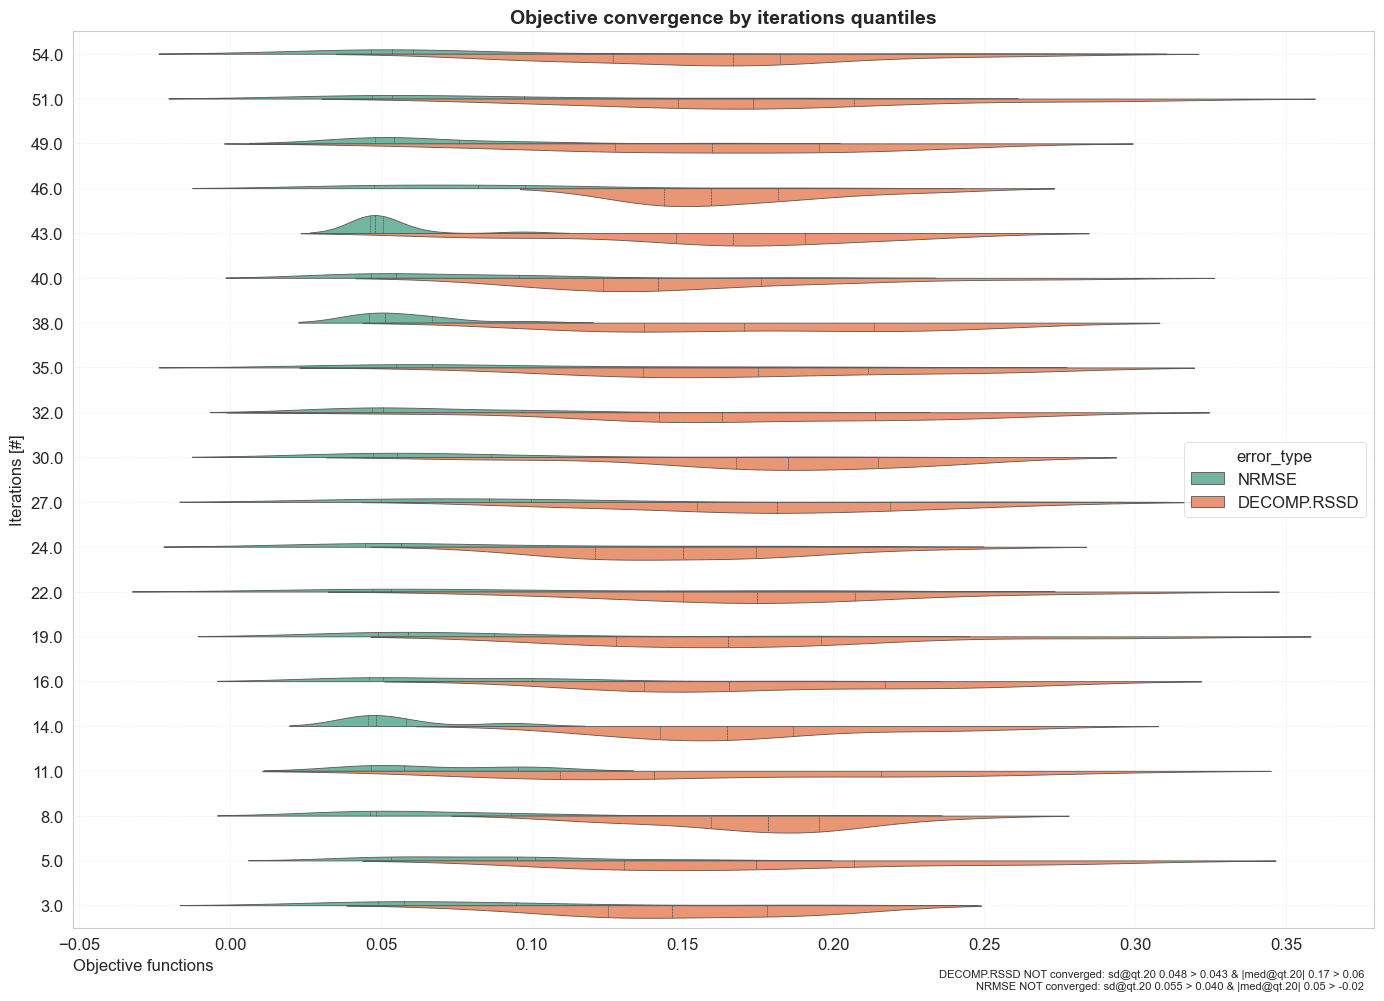

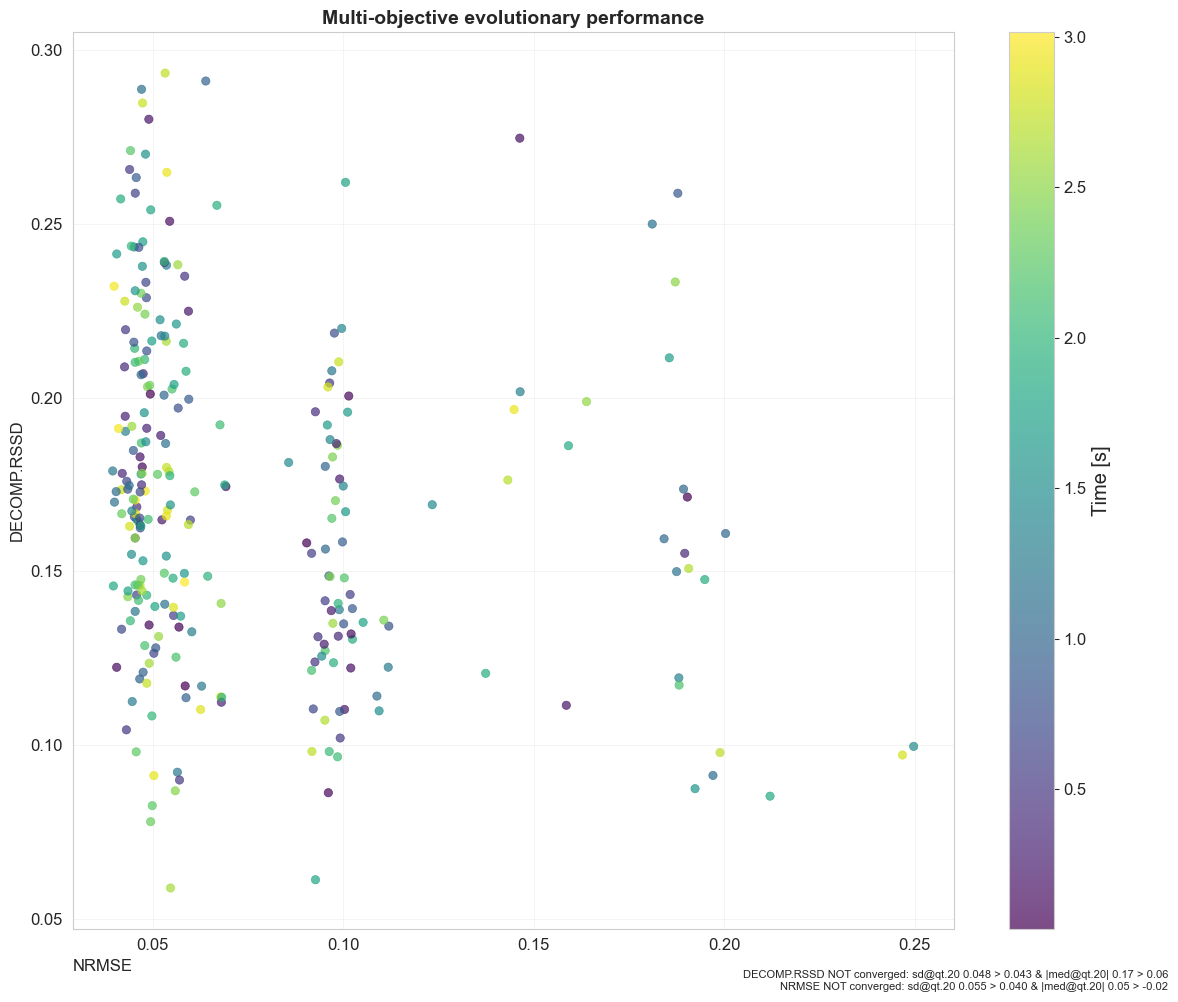

In [8]:
model_executor = ModelExecutor(
    mmmdata=mmm_data,
    holidays_data=holidays_data,
    hyperparameters=hyperparameters,
    calibration_input=None,
    featurized_mmm_data=featurized_mmm_data,
)

trials_config = TrialsConfig(iterations=54, trials=5)

output_models = model_executor.model_run(
    trials_config=trials_config,
    ts_validation=True,
    add_penalty_factor=False,
    rssd_zero_penalty=True,
    cores=8,
    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
    intercept=True,
    intercept_sign="non_negative",
    model_name=Models.RIDGE,
)

## Model Selection and Clustering

### 1. Pareto Optimization
Pareto optimization helps select the best models by balancing multiple objectives:
- Model accuracy (NRMSE)
- Decomposition accuracy
- Model robustness

Parameters:
- `pareto_fronts`: Number of Pareto fronts to consider ("auto" recommended)
- `min_candidates`: Minimum number of models to retain (e.g., 100)

In [9]:
from robyn.modeling.pareto.pareto_optimizer import ParetoOptimizer

# 3. Create ParetoOptimizer instance
pareto_optimizer = ParetoOptimizer(
    mmm_data, output_models, hyperparameters, featurized_mmm_data, holidays_data
)

# 4. Run optimize function
pareto_result = pareto_optimizer.optimize(pareto_fronts="auto", min_candidates=100)

2024-12-06 18:55:34 [INFO] Starting Pareto optimization
2024-12-06 18:55:34,949 - robyn.modeling.pareto.data_aggregator - INFO - Starting model data aggregation
2024-12-06 18:55:34 [INFO] Computing Pareto fronts
2024-12-06 18:55:34 [INFO] Pareto front computation completed
2024-12-06 18:55:34 [INFO] Preparing Pareto data
2024-12-06 18:55:34 [INFO] Number of Pareto-optimal solutions found: 219
2024-12-06 18:55:34 [INFO] Selected 9 Pareto-fronts containing 104 candidates
2024-12-06 18:55:34 [INFO] Selected Pareto fronts: 10
2024-12-06 18:55:34 [INFO] Filtering data for selected Pareto fronts...
2024-12-06 18:55:34 [INFO] Pareto data preparation completed
2024-12-06 18:55:34,986 - robyn.modeling.pareto.response_curve - INFO - Calculating response curves for 520 models' media variables...
Processing rows: 100%|██████████| 520/520 [00:04<00:00, 108.97it/s]
2024-12-06 18:55:40,416 - robyn.modeling.pareto.response_curve - INFO - Successfully processed 520 response curves
2024-12-06 18:55:40,4

### 2. Model Clustering
Clustering groups similar models together to identify stable solutions.

Configuration parameters:
- `dep_var_type`: Type of dependent variable (revenue/conversion)
- `cluster_by`: Clustering criterion (HYPERPARAMETERS recommended)
- `max_clusters`: Maximum number of clusters to consider
- `min_clusters`: Minimum number of clusters
- `weights`: Importance weights for clustering criteria

In [10]:
from robyn.modeling.clustering.clustering_config import ClusteringConfig, ClusterBy
from robyn.modeling.clustering.cluster_builder import ClusterBuilder
from robyn.data.entities.enums import DependentVarType
import plotly.io as pio

pio.renderers.default = "iframe"

cluster_configs = ClusteringConfig(
    dep_var_type=DependentVarType(mmm_data.mmmdata_spec.dep_var_type),
    cluster_by=ClusterBy.HYPERPARAMETERS,
    max_clusters=10,
    min_clusters=3,
    weights=[1.0, 1.0, 1.0],
)

cluster_builder = ClusterBuilder(pareto_result=pareto_result)


cluster_results = cluster_builder.cluster_models(cluster_configs)

2024-12-06 18:55:49,840 - robyn.modeling.clustering.cluster_builder - INFO - Initializing ClusterBuilder
2024-12-06 18:55:49,840 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-12-06 18:55:49,841 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-12-06 18:55:49,841 - robyn.modeling.clustering.cluster_builder - INFO - ClusterBuilder initialization complete
2024-12-06 18:55:49,842 - robyn.modeling.clustering.cluster_builder - INFO - Starting model clustering process
2024-12-06 18:55:49,843 - robyn.modeling.clustering.cluster_builder - INFO - Auto-detected media channels: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
2024-12-06 18:55:49,844 - robyn.modeling.clustering.cluster_builder - INFO - Clustering by: ClusterBy.HYPERPARAMETERS
2024-12-06 18:55:49,845 - robyn.modeling.clustering.cluster_builder - INFO - Starting optimal cluster selection
2024-12-06 18:55:49,845 - robyn.mode

## Reestablish Pareto Results

In [11]:
from robyn.modeling.pareto.pareto_utils import ParetoUtils

utils = ParetoUtils()
pareto_result = utils.process_pareto_clustered_results(
    pareto_result,
    clustered_result=cluster_results,
    ran_cluster=True,
    ran_calibration=False,
)

## Budget Allocation Optimization

Robyn provides different scenarios for budget allocation optimization. Let's explore the "max_response" scenario:

### Scenario: Maximum Response
This scenario answers the question: "What's the maximum return given certain spend constraints?"

Key parameters:
- `total_budget`: When set to None, uses the total spend in the selected date range
- `channel_constr_low`: Minimum spend multiplier (e.g., 0.7 means channel spend can't go below 70% of current)
- `channel_constr_up`: Maximum spend multiplier per channel (e.g., 1.5 means channel spend can't exceed 150% of current)
- `channel_constr_multiplier`: Extends bounds for wider optimization insights
- `date_range`: Period for optimization ("all", "last_X", or specific date range)

Note: Other scenarios include:
- "target_efficiency": Optimize spend to hit specific ROAS or CPA targets
- "min_spend": Find minimum spend required to hit response targets
- "max_response_expected": Maximize expected response within confidence intervals

For this example, we'll demonstrate the "max_response" scenario:

In [12]:
from robyn.allocator.entities.allocation_params import AllocatorParams
from robyn.allocator.entities.allocation_result import (
    AllocationResult,
    OptimOutData,
    MainPoints,
)
from robyn.allocator.entities.optimization_result import OptimizationResult
from robyn.allocator.entities.constraints import Constraints
from robyn.allocator.optimizer import BudgetAllocator
from robyn.allocator.constants import (
    SCENARIO_MAX_RESPONSE,
    ALGO_SLSQP_AUGLAG,
    CONSTRAINT_MODE_EQ,
    DEFAULT_CONSTRAINT_MULTIPLIER,
    DATE_RANGE_ALL,
)

select_model = pareto_result.pareto_solutions[1]

# Create allocator parameters matching R Example 1
allocator_params = AllocatorParams(
    scenario=SCENARIO_MAX_RESPONSE,
    total_budget=None,  # When None, uses total spend in date_range
    target_value=None,
    date_range="all",
    channel_constr_low=[0.7],  # Single value for all channels
    channel_constr_up=[1.2, 1.5, 1.5, 1.5, 1.5],  # Different values per channel
    channel_constr_multiplier=3.0,
    optim_algo="SLSQP_AUGLAG",
    maxeval=100000,
    constr_mode=CONSTRAINT_MODE_EQ,
    plots=True,
)

# Initialize budget allocator
max_response_allocator = BudgetAllocator(
    mmm_data=mmm_data,
    featurized_mmm_data=featurized_mmm_data,
    hyperparameters=hyperparameters,
    pareto_result=pareto_result,
    select_model=select_model,
    params=allocator_params,
)

## Step 3: Run Optimization
max_response_result = max_response_allocator.optimize()

## Analyze Results

Create summary of optimization results:

In [13]:
import numpy as np

results_df = pd.DataFrame(
    {
        "Channel": max_response_result.dt_optimOut.channels,
        "Initial Spend": max_response_result.dt_optimOut.init_spend_unit,
        "Optimized Spend": max_response_result.dt_optimOut.optm_spend_unit,
        "Spend Change %": (
            max_response_result.dt_optimOut.optm_spend_unit
            / max_response_result.dt_optimOut.init_spend_unit
            - 1
        )
        * 100,
        "Initial Response": max_response_result.dt_optimOut.init_response_unit,
        "Optimized Response": max_response_result.dt_optimOut.optm_response_unit,
        "Response Lift %": (
            max_response_result.dt_optimOut.optm_response_unit
            / max_response_result.dt_optimOut.init_response_unit
            - 1
        )
        * 100,
    }
)

print(results_df.round(2))

      Channel  Initial Spend  Optimized Spend  Spend Change %  \
0        tv_S       16282.26         19538.71           20.00   
1       ooh_S       52818.55         45726.67          -13.43   
2     print_S        3856.63          5784.95           50.00   
3  facebook_S        2141.53          1499.07          -30.00   
4    search_S        5099.15          7648.72           50.00   

   Initial Response  Optimized Response  Response Lift %  
0          41166.74            44255.29             7.50  
1           7108.97             6464.39            -9.07  
2           1016.44             2744.07           169.97  
3            -90.18              -54.24           -39.85  
4           1742.35             3264.51            87.36  


## Visualize Results

Generate allocation visualization plots:

2024-12-06 18:55:53,086 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-12-06 18:55:53,087 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-12-06 18:55:53,087 - robyn.visualization.allocator_visualizer - INFO - Initializing AllocatorPlotter
2024-12-06 18:55:53,088 - robyn.visualization.allocator_visualizer - INFO - Creating all plots for model 4_42_1
2024-12-06 18:55:53,088 - robyn.visualization.allocator_visualizer - INFO - Creating budget comparison plot
2024-12-06 18:55:53,117 - robyn.visualization.allocator_visualizer - INFO - Creating allocation matrix plot
2024-12-06 18:55:53,318 - robyn.visualization.allocator_visualizer - INFO - Creating response curves plot


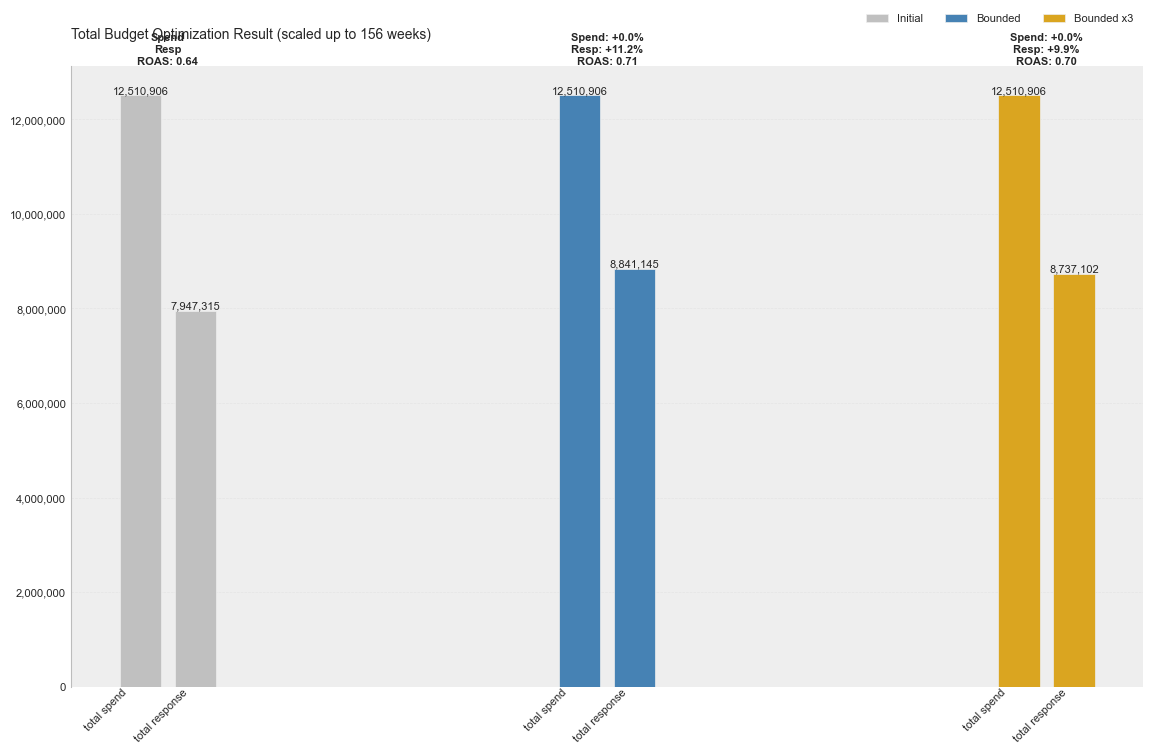

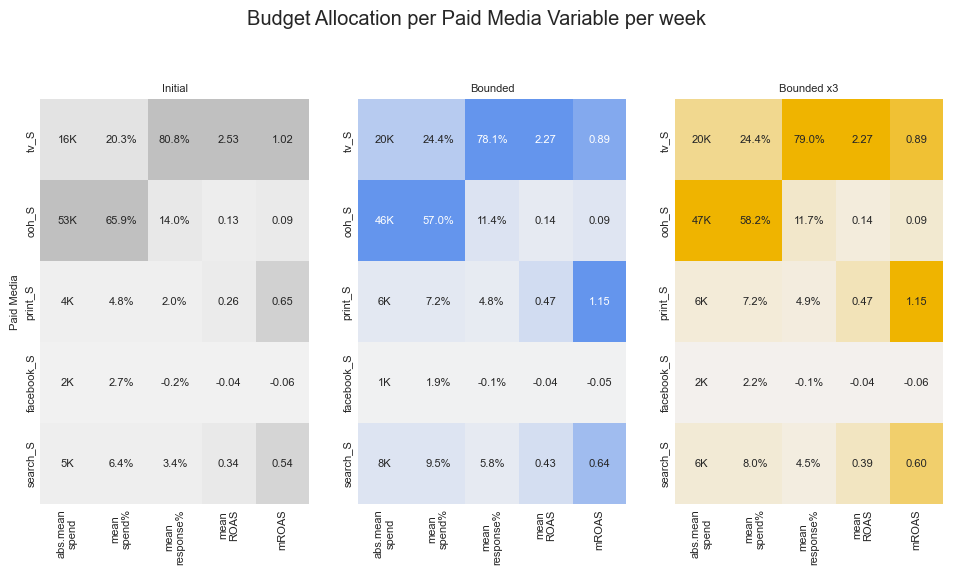

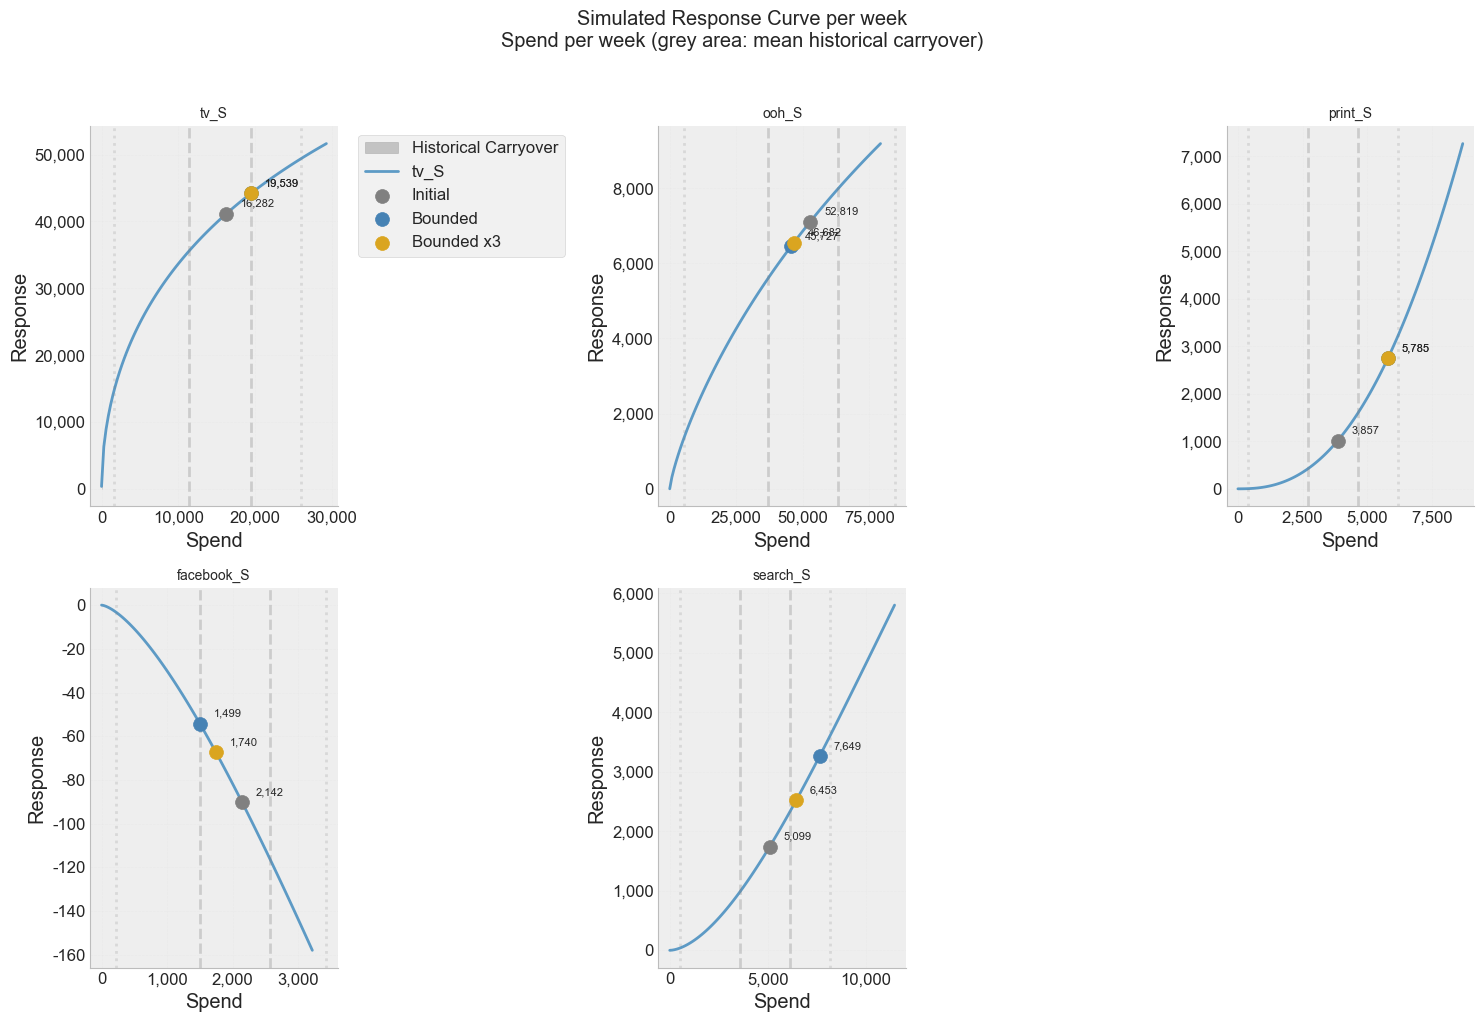

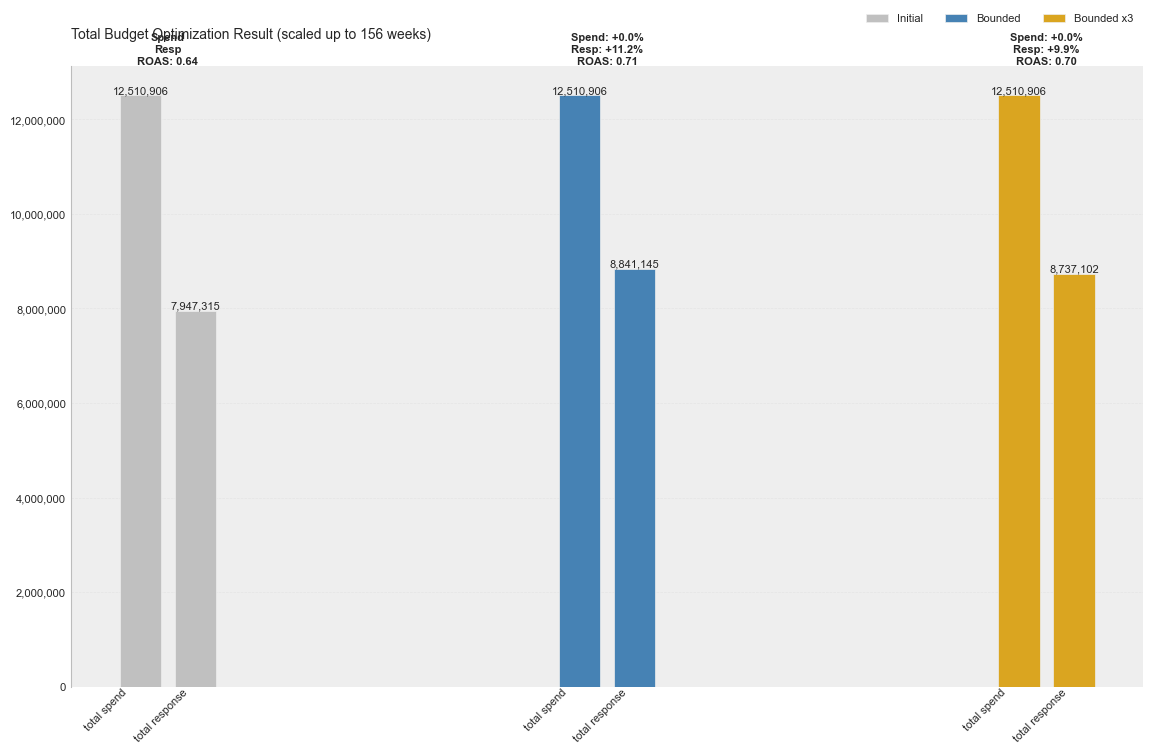

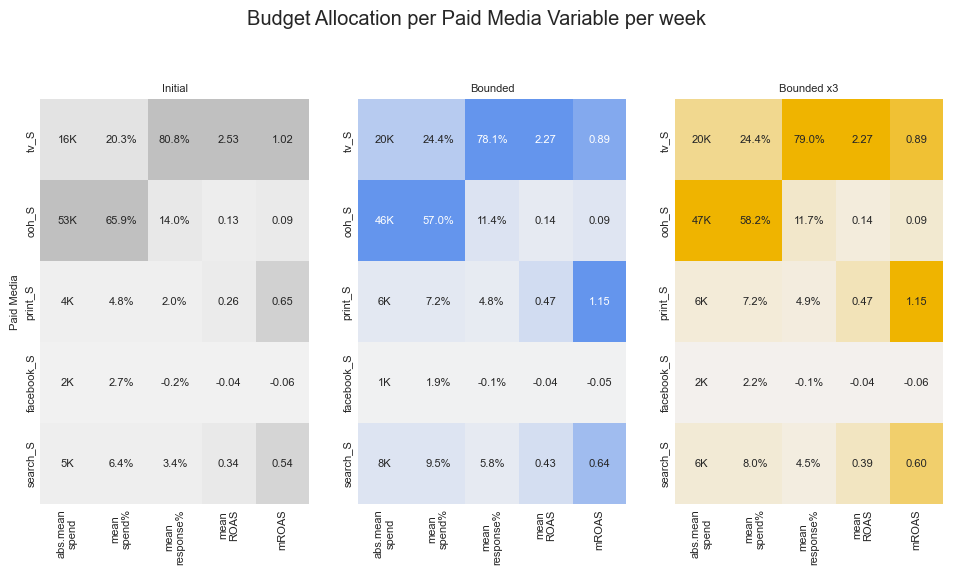

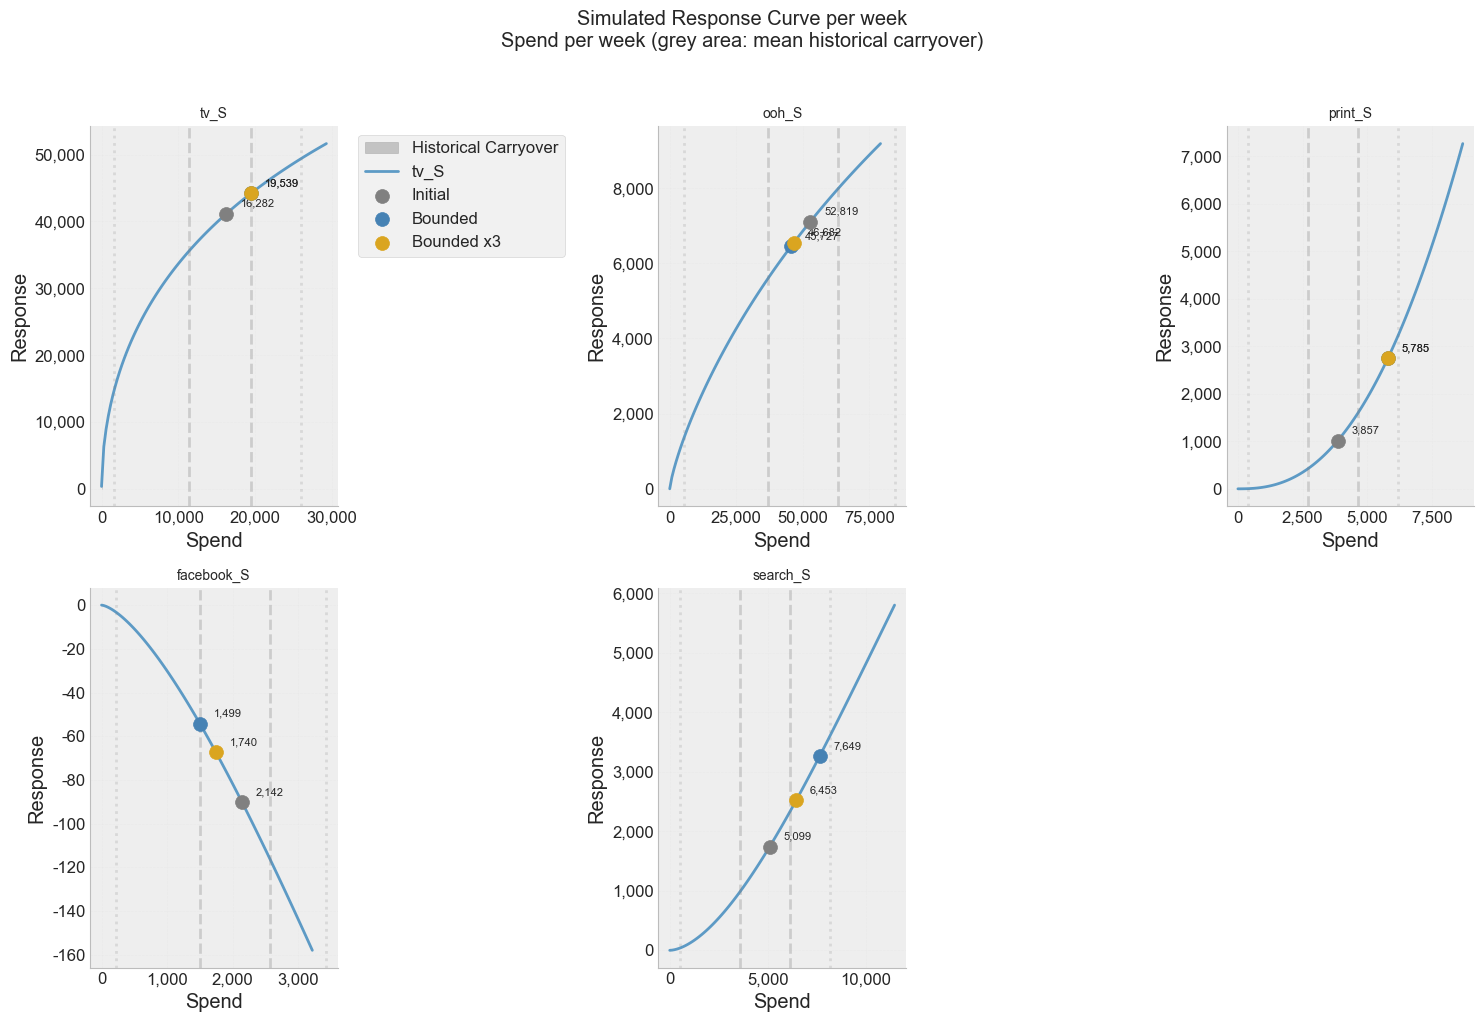

In [14]:
from robyn.visualization.allocator_visualizer import AllocatorPlotter

plotter = AllocatorPlotter(
    allocation_result=max_response_result, budget_allocator=max_response_allocator
)

plots = plotter.plot_all(display_plots=True, export_location=None)